# Calculate Detector Counts: Ionization Equilibrium
Calculate the detector counts, this time assuming ionization equilibrium. Were we to include all ions (plus continuum), this is mostly equivalent to using the pre-computed temperature response functions.

In [40]:
import os

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
import distributed

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import EmissionModel
from synthesizAR.interfaces import EbtelInterface
import synthesizAR.maps

%matplotlib inline

In [2]:
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:38084 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Reload the selected field

In [4]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/field_checkpoint/')

And emission model

In [6]:
em_model = EmissionModel.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_emission_model.json')

In [7]:
em_model.calculate_ionization_fraction(field,
                                    '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/ieq/ionization_fractions.h5')

FloatProgress(value=0.0)

In [8]:
em_model.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/ieq/emission_model_dominant.json')

In [9]:
aia = InstrumentSDOAIA([0,10000]*u.s, use_temperature_response_functions=False)

In [10]:
observer = synthesizAR.Observer(field,[aia],parallel=True)

In [11]:
observer.build_detector_files('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/ieq/',
                              ds=0.5 * u.Mm)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [12]:
tasks = observer.flatten_detector_counts(emission_model=em_model)

In [13]:
tasks['SDO_AIA_parameters'].compute()

In [14]:
tasks['SDO_AIA_counts'].compute()

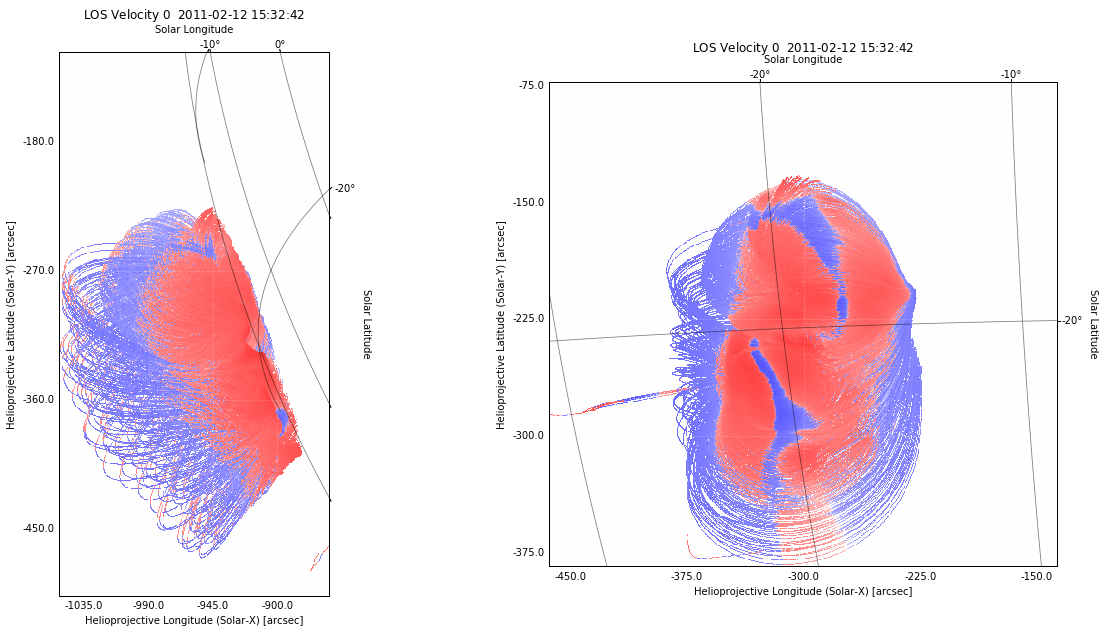

In [58]:
hgs_center = field.magnetogram.center.transform_to('heliographic_stonyhurst')
aia.observer_coordinate = SkyCoord(lon=90 * u.deg + hgs_center.lon,
                                   lat=hgs_center.lat,#90 * u.deg + hgs_center.lat,
                                   radius=field.magnetogram.observer_coordinate.radius,
                                   frame='heliographic_stonyhurst')
aia.make_detector_array(field)
m = synthesizAR.maps.make_los_velocity_map(1000 * u.s, field, aia,)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121,projection=m)
im = m.plot(axes=ax)
m.draw_grid(axes=ax,color='k',grid_spacing=10 * u.deg)
aia.observer_coordinate = SkyCoord(lon=field.magnetogram.observer_coordinate.lon,
                                   lat=field.magnetogram.observer_coordinate.lat,
                                   radius=field.magnetogram.observer_coordinate.radius,
                                   frame='heliographic_stonyhurst')
aia.make_detector_array(field)
m = synthesizAR.maps.make_los_velocity_map(1000 * u.s, field, aia,)
ax = fig.add_subplot(122,projection=m)
im = m.plot(axes=ax)
m.draw_grid(axes=ax,color='k',grid_spacing=10 * u.deg)

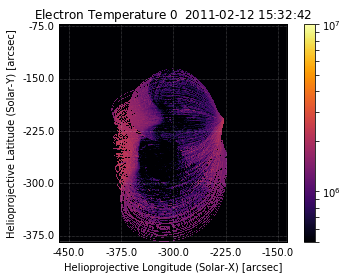

In [60]:
m = synthesizAR.maps.make_temperature_map(5000 * u.s, field, aia,)
fig = plt.figure()
ax = fig.gca(projection=m)
im = m.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=5e5,vmax=1e7))
fig.colorbar(im)

In [59]:
aia.observer_coordinate = field.magnetogram.observer_coordinate

In [61]:
tasks = observer.bin_detector_counts('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/ieq/')

In [62]:
jobs = client.compute(tasks['SDO_AIA'])

In [63]:
jobs = None

In [ ]:
client.close()